In [1]:
from keras.utils import plot_model
import prophet as ph
import pandas as pd
import numpy as np
import time

Using TensorFlow backend.


## Plot nets

In [3]:
plot_model(ph.prophet1(), to_file='ph1.png', show_shapes=True)
plot_model(ph.prophet2(), to_file='ph2.png', show_shapes=True)

## Data generator

In [2]:
import requests
def bitfinex(tf, pair, limit=1000):
    url = 'https://api.bitfinex.com/v2/candles/trade:{}:t{}/hist?limit={}'.format(tf, pair, limit)
    request = requests.get(url)
    response = request.json()
    points = []
    if isinstance(response, list) and response[0] != 'error':
        count = 0 
        for row in response:  
            json_body = {
                        "open": float(row[1]),
                        "close": float(row[2]),
                        "high": float(row[3]),
                        "low": float(row[4]),
                        "volume": float(row[5]),
                        }
            points.append(json_body)
    
    return pd.DataFrame(points)

In [6]:
# timeframes = ['1h', '3h', '6h', '12h', '24h']
# pairs = ['BTCUSD', 'NEOUSD', 'ETHUSD', 'LTCUSD']

# for p in pairs:
#     for t in timeframes:
#         try:
#             df = bitfinex(t, p)
#             df.to_pickle(f'bitfinex_{p}:{t}.pkl')
#             time.sleep(4)
#         except:
#             print(f'Failed: {p}:{t}')
#             pass

Failed: BTCUSD:24h
Failed: NEOUSD:24h
Failed: ETHUSD:24h
Failed: LTCUSD:24h


## Helpers

In [114]:
def normalize_price(df):
    M = np.max(df.high.values)
    m = np.min(df.low.values)
    d = M - m
    
    df['close'] = (df.close.values-m)/d
    df['open'] = (df.open.values-m)/d
    df['high'] = (df.high.values-m)/d
    df['low'] = (df.low.values-m)/d
    
    Mv = np.max(df.volume.values)
    mv = np.min(df.volume.values)
    df['volume'] = (df.volume.values - mv)/Mv
    
    return df

def reverse(arr: np.array, M, m):
    d = M-m
    arr = d * arr + m
    return arr

def make_observations(df, size):
    C = df.close.values
    L = df.low.values
    H = df.high.values
    O = df.open.values
    n = df.shape[0]-(size+1)
    output = pd.DataFrame([])
    for i in range(n):
        data = {f'x{i}':[c] for i, c in enumerate(C[i:i+size])}
        data.update(y=C[i+size])
        output = pd.concat([output, pd.DataFrame(data)], ignore_index=True)
    return output
        

def agg_pair(pair, size, timeframes=['3h', '6h', '12h']):
    output = normalize_price(pd.read_pickle(f'bitfinex_{pair}:1h.pkl'))
    output = make_observations(output, size)
    for t in timeframes:
        tmp = pd.read_pickle(f'bitfinex_{pair}:{t}.pkl')
        tmp = normalize_price(tmp)
        tmp = make_observations(tmp, size)
        output = pd.concat([output, tmp], ignore_index=True)
    
    return output

def agg_data(size, pairs = ['BTCUSD', 'NEOUSD', 'ETHUSD', 'LTCUSD']):
    output = agg_pair('BTCUSD', size)
    for p in pairs:
        tmp = agg_pair(p, size)
        output = pd.concat([output, tmp], ignore_index=True)
    return output
        

In [281]:
size = 10
data = agg_data(size)
data.to_pickle(f'merged_norm_data_{size}.pkl')
print(data.shape)
data.head(5)

## Models

In [285]:
from sklearn.model_selection import train_test_split

def reshape(arr):
    return arr.reshape(arr.shape[0],arr.shape[1],1)

In [286]:
X = data.iloc[:, data.columns != 'y'].values
Y = data.y.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = reshape(X_train)
X_test = reshape(X_test)

X_train[0]

In [290]:
model = ph.prophet1(ts_input_shape=X_train[0].shape[0], lstm_size=100, num_dense=4)

In [291]:
results = model.fit(
 X_train, y_train,
 epochs= 5,
 batch_size = 200
)

Epoch 1/5
15824/15824 [==============================] - 4s 228us/step - loss: 0.0236
Epoch 2/5
15824/15824 [==============================] - 2s 146us/step - loss: 0.0026
Epoch 3/5
15824/15824 [==============================] - 2s 145us/step - loss: 9.6215e-04
Epoch 4/5
15824/15824 [==============================] - 2s 148us/step - loss: 9.2259e-04
Epoch 5/5
15824/15824 [==============================] - 3s 159us/step - loss: 9.2027e-04


In [292]:
y_hat = model.predict(X_test[:200])
y = y_test[:200]

## Plots / tests

In [84]:
import matplotlib.pyplot as plt

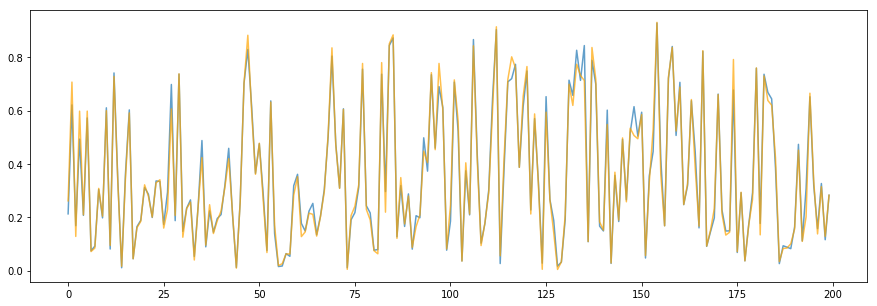

In [293]:
plt.figure(figsize=(15, 5))
# x = np.arange(y_hat.size)
plt.plot(y_hat, alpha=0.7)
plt.plot(y, color='orange', alpha=0.7)
plt.show()

In [300]:
sample = pd.read_pickle('bitfinex_BTCUSD:1h.pkl')
sample = sample.iloc[100:700]
sample = normalize_price(sample)

print(sample.head(), sample.shape)

close = sample.close.values
close = close.reshape(close.size, 1)
close.shape

        close      high       low      open    volume
100  0.232011  0.249339  0.226323  0.226455  0.026604
101  0.226455  0.251984  0.225265  0.238990  0.025488
102  0.238889  0.241931  0.219180  0.224074  0.046583
103  0.224251  0.259392  0.178175  0.192109  0.189599
104  0.192063  0.192725  0.186508  0.191799  0.015582 (600, 5)


In [302]:
def gaze(x:np.array, size=50):
    prophecy = [model.predict([[close[i:i+size]]])[0][0] for i in range(x.size-size)]
    return np.array(prophecy)
    

<function matplotlib.pyplot.show(*args, **kw)>

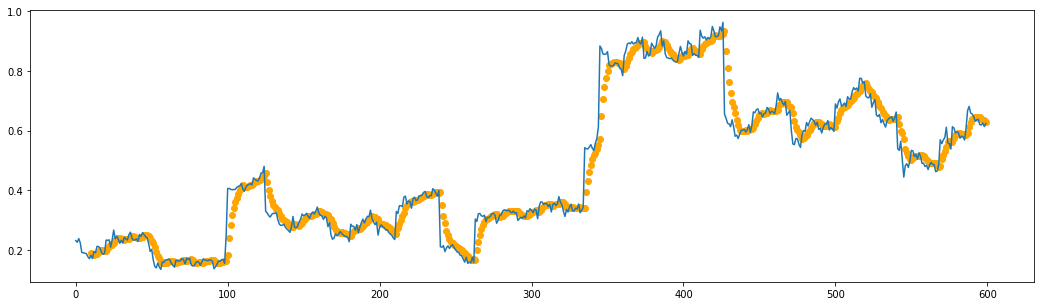

In [307]:
size = 10
close_hat = gaze(close, size)

plt.figure(figsize=(18, 5))
plt.plot(close)
x = np.arange(close_hat.size)+size
plt.scatter(x, close_hat, color='orange')
plt.show

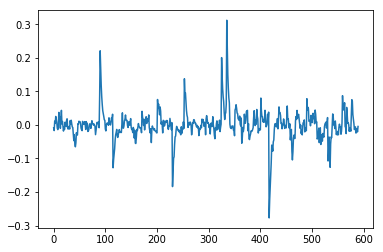

mean  0.0005380244419236621


In [327]:
real_close = close[size:].reshape(1, close[size:].shape[0])[0]
dif = (real_close-close_hat)
plt.plot(dif)
plt.show()

print('mean ', np.mean(dif))

In [335]:
direction = np.array([1 if x/y >= 1 else 0 for x,y in zip(real_close[1:], real_close[:-1])])
direction_hat = np.array([1 if x/y >= 1 else 0 for x,y in zip(close_hat[1:], close_hat[:-1])])

In [342]:
diff = direction-direction_hat
print('Points with different dir :'   , len([x for x in diff if x==-1])/diff.size)
print('Difference :'   , np.sum(direction-direction_hat))
np.sum(direction-direction_hat)/direction.size


Points with different dir : 0.300509337860781
Difference : -36


-0.06112054329371817